## There are a total of 1288 images (n_samples) each having 1850 pixels
## There are 7 classes/persons (n_classes)
## Pixel value range is between 0 and 255


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Pixel range: [0.0 , 255.0]


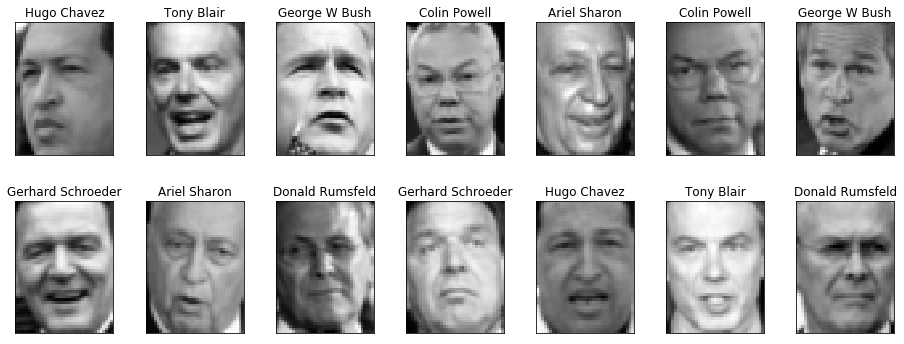

In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from collections import Counter
import numpy as np


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

###### part b #####

print("Pixel range: [%s , %s]" % (np.matrix(X).min(), np.matrix(X).max()))
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


plotted = []
my_titles = []
my_persons = []
for i in range(100):
    if Counter(plotted)[y[i]] < 2:
        plotted.append(y[i])
        my_persons.append(X[i])
        my_titles.append(target_names[y[i]])

plot_gallery(my_persons, my_titles, h, w, 2, 7)
plt.show()
##### end part b #####

## Above are 2 examples of each person from the dataset

Extracting the top 150 eigenfaces from 966 faces
done in 0.209s
Eigenvalues:  [ 488864.875       386836.15625     185702.078125    152609.265625
  139137.515625     78337.71875      65221.27734375   54412.93359375
   53437.40625      49444.19140625   42830.22265625   39387.625
   31903.27539062   28791.20703125   27938.70507812   26373.66015625
   23879.96679688   23356.77734375   21342.29882812   18698.87890625
   17570.44140625   16650.50976562   16215.20996094   15737.54492188
   14316.85644531   13694.31542969   13125.15917969   12361.765625
   11858.36328125   11060.71386719    9985.88769531    9668.00390625
    9492.828125      9122.609375      9003.39453125    8664.125
    8337.93261719    7941.38085938    7806.64941406    7544.40136719
    7322.27148438    7101.9453125     6717.84863281    6501.86474609
    6315.55126953    6166.53759766    6059.38818359    5920.64355469
    5744.92089844    5654.32666016    5512.97167969    5402.51904297
    5110.00830078    5074.58984375    5

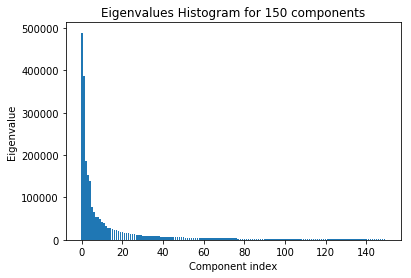

Projecting the input data on the eigenfaces orthonormal basis
Projection Error for 150 components:  61.0155
done in 0.068s
Fitting the classifier to the training set
done in 23.223s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.050s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.59      0.74        22
     Colin Powell       0.87      0.83      0.85        71
  Donald Rumsfeld       0.96      0.79      0.87        29
    George W Bush       0.81      0.98      0.89       130
Gerhard Schroeder       0.96      0.82      0.88        28
      Hugo Chavez       1.00      0.69      0.81        16
       Tony Blair       0.92      0.88      0.90        26

      avg / total

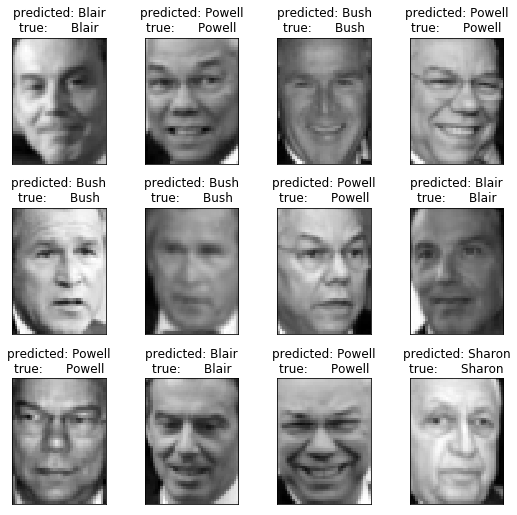

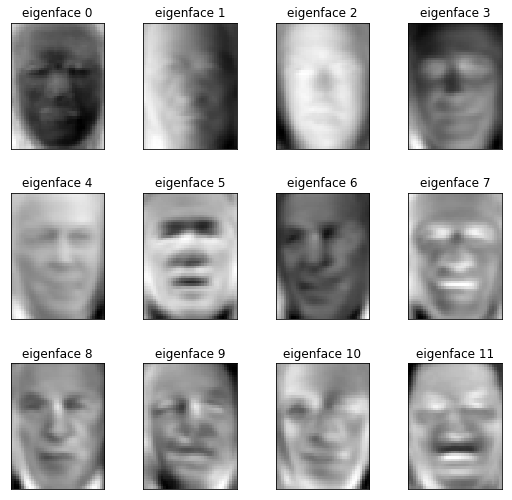

In [3]:

###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)


###############################################################################

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(svd_solver='randomized', n_components=n_components, whiten=True).fit(X_train)



print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenvalues = pca.explained_variance_
print("Eigenvalues: ", eigenvalues)

plt.bar(range(n_components), eigenvalues)
plt.title("Eigenvalues Histogram for 150 components")
plt.ylabel("Eigenvalue")
plt.xlabel("Component index")
plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)

X_train_projected = pca.inverse_transform(X_train_pca)
loss = ((X_train - X_train_projected)**2).mean()
print("Projection Error for 150 components: ", loss) # for 150 components error is 61 %

X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)





###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## The projection error for 150 components is 61 %

Extracting the top 50 eigenfaces from 966 faces
done in 0.182s


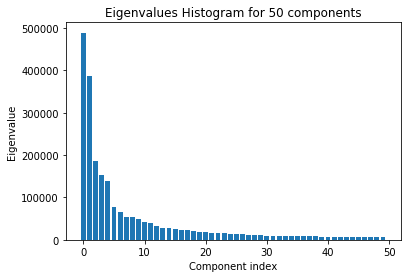

Projecting the input data on the eigenfaces orthonormal basis
Projection Error for 50 components:  193.302
done in 0.059s
Fitting the classifier to the training set
done in 7.565s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.017s
                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.91      0.90      0.91        71
  Donald Rumsfeld       0.62      0.69      0.66        29
    George W Bush       0.87      0.91      0.89       130
Gerhard Schroeder       0.75      0.64      0.69        28
      Hugo Chavez       1.00      0.88      0.93        16
       Tony Blair       0.74      0.88      0.81        26

      avg / total   

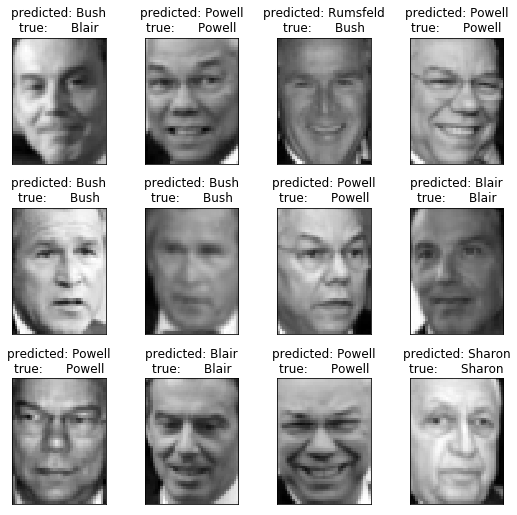

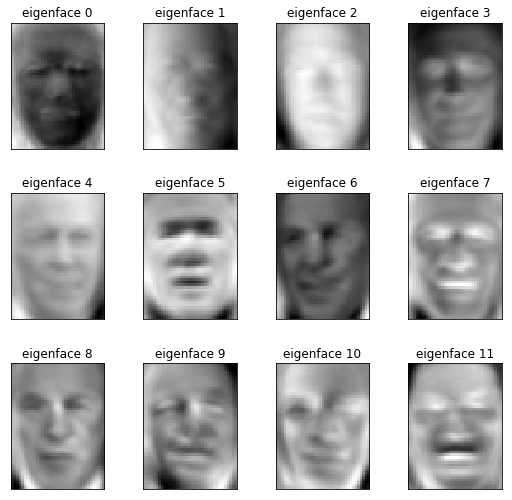

In [4]:

################ Test with 50 components ###########################

n_components = 50

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(svd_solver='randomized', n_components=n_components, whiten=True).fit(X_train)



print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenvalues = pca.explained_variance_

plt.bar(range(n_components), eigenvalues)
plt.title("Eigenvalues Histogram for 50 components")
plt.ylabel("Eigenvalue")
plt.xlabel("Component index")
plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)

X_train_projected = pca.inverse_transform(X_train_pca)
loss = ((X_train - X_train_projected)**2).mean()
print("Projection Error for 50 components: ", loss) # for 150 components error is 61 %

X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)





###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## The projection error for 50 components is 193 %

Extracting the top 250 eigenfaces from 966 faces
done in 0.349s


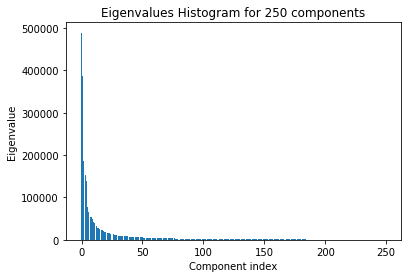

Projecting the input data on the eigenfaces orthonormal basis
Projection Error for 250 components:  26.1578
done in 0.084s
Fitting the classifier to the training set
done in 40.441s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.080s
                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.64      0.72        22
     Colin Powell       0.84      0.82      0.83        71
  Donald Rumsfeld       0.75      0.72      0.74        29
    George W Bush       0.85      0.88      0.86       130
Gerhard Schroeder       0.75      0.75      0.75        28
      Hugo Chavez       0.87      0.81      0.84        16
       Tony Blair       0.79      0.88      0.84        26

      avg / total

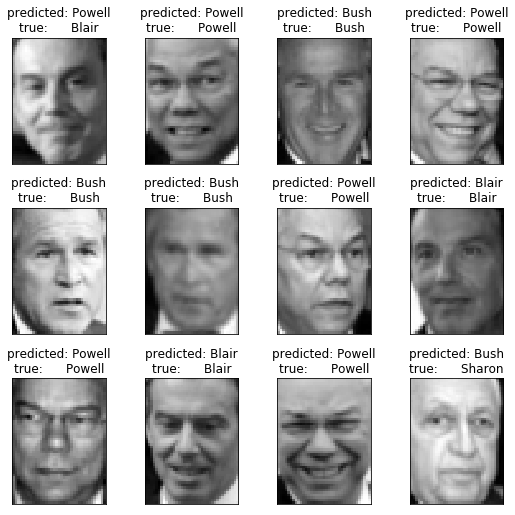

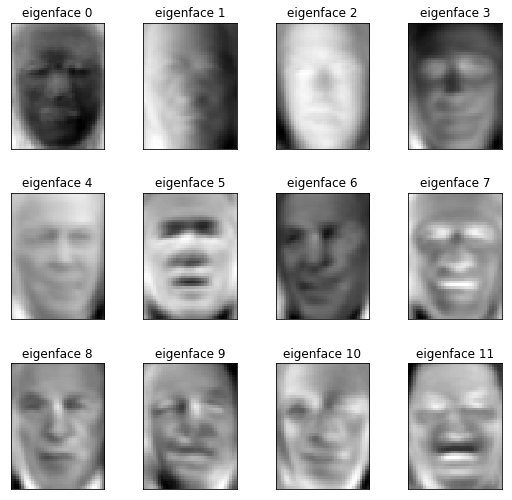

In [5]:
################ Test with 250 components ###########################

n_components = 250

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(svd_solver='randomized', n_components=n_components, whiten=True).fit(X_train)



print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))
eigenvalues = pca.explained_variance_

plt.bar(range(n_components), eigenvalues)
plt.title("Eigenvalues Histogram for 250 components")
plt.ylabel("Eigenvalue")
plt.xlabel("Component index")
plt.show()

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)

X_train_projected = pca.inverse_transform(X_train_pca)
loss = ((X_train - X_train_projected)**2).mean()
print("Projection Error for 250 components: ", loss) # for 150 components error is 61 %

X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)





###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## The projection error for 250 components is 26 %

## As it can be seen this algorithm has a projection error of 26 % and we cannot really improve it by adding more components to the PCA. Therefore it is not really reliable for passport photo recognition, considering that CNNs nowadays have an accuracy between 95 to 97 percent
